## Calculate result matrices

- Script edited by Younghyun Koo (kooala317@gmail.com)
- Submitted to Journal of Glaciology (JOG-2024-0049)
- Title: **"Graph Convolutional Network as a Fast Statistical Emulator for Numerical Ice Sheet Modeling"**


In [27]:
# Import necessary libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
# Define necessary functions
def RMSE(prd, obs):
    # Function to calculate root mean square error (RMSE)
    err = np.square(obs-prd)
    return np.nanmean(err)**0.5

def corr(prd, obs):
    # Function to calculate correlation coefficient (R)
    prd = prd.flatten()
    obs = obs.flatten()
    r = np.corrcoef(np.ma.masked_invalid(prd), np.ma.masked_invalid(obs))[0, 1]
    return r

In [29]:
model_type = "gcn" # model name: ["gcn", "fcn", "mlp"]
grid = 5000 # Initial mesh resolution: [5000]
with open(f'results_{model_type}_m{grid}.pkl', 'rb') as handle:
    xc, yc, y_true_all, y_pred_all = pickle.load(handle)
    # xc, yc: x and y geocoordinates of the unstructured meshes
    # y_true_all: Ground truth (ISSM simulation results)
    # y_pred_all: Prediction emulators (emulator results)
    ### NOTE for true and prediction arrays
    ### dimension: 4 x 40 x 2852 x 3
    ############## 4 = four test melting rates
    ############## 40 = time steps (it should be 240, but this array only includes the results every 6 month)
    ############## 2853 = the number of nodes
    ############## 3 = output variables (X-velocity, Y-velocity, thickness)

In [23]:
pig_rmse = np.zeros((4, 3)) # RMSE for 4 melting rates X 3 output variables
pig_r = np.zeros((4, 3)) # R for 4 melting rates X 3 output variables

# Calculate RMSE and R for 4 melting rates X 3 output variables
for i in range(0, 4):
    for c in range(0, 3):
        pig_rmse[i, c] = RMSE(y_pred_all[i, :, :, c], y_true_all[i, :, :, c])
        pig_r[i, c] = corr(y_pred_all[i, :, :, c], y_true_all[i, :, :, c])

df_v = pd.DataFrame({}) # Mean RMSE & R for ice velocity
df_h = pd.DataFrame({}) # Mean RMSE & R for ice thickness

# Calculate the mean RMSE and R of 4 melting rates
df_v.loc[model_type, "RMSE"] =  np.mean(pig_rmse[:, :2])
df_h.loc[model_type, "RMSE"] = np.mean(pig_rmse[:, 2])
df_v.loc[model_type, "R"] = np.mean(pig_r[:, :2])
df_h.loc[model_type, "R"] =np.mean(pig_r[:, 2])

In [24]:
# RMSE and R of ice velocity (m/year)
df_v

,RMSE,R
gcn,54.434252,0.99799


In [25]:
# RMSE and R of ice thickness (m)
df_h

,RMSE,R
gcn,13.016594,0.999811


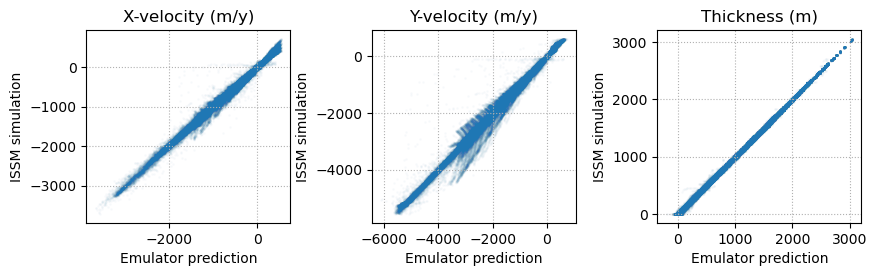

In [26]:
# Draw scatter plots between Emulator prediction and ISSM simulation
fig, ax = plt.subplots(1,3, figsize = (10, 2.5))
plt.subplots_adjust(wspace=0.4)
labels = ["X-velocity (m/y)", "Y-velocity (m/y)", "Thickness (m)"]
for c in [0, 1, 2]:
    ax[c].scatter(y_pred_all[:, :, :, c], y_true_all[:, :, :, c], alpha = 0.02, s = 1)
    ax[c].set_title(labels[c])
    ax[c].set_xlabel("Emulator prediction")
    ax[c].set_ylabel("ISSM simulation")
    ax[c].grid(ls = ":")